![image](https://www.ewatercycle.org/img/logo.png)

# Case study 1: replace subbasin in PCRGlobWB2.0 with a MARRMoT model
This notebooks demonstrates how to use eWaterCycle to combine the output of two very different models in a single experiment. We run PCRGlobWB2.0 for the Rhine basin, but we replace the Moselle sub-basin with a MARRMoT model.

PCRGlobWB2.0 (Edwin 20XX) is a distributed model written in python and MARRMoT (Knoben 20XX) is a suite of conceptual models written in Matlab. To make the difference as large as possible, we choose the simplest model available within MARRMoT: the m01, a single leaky bucket.

## Import statements
We'll be using the following modules

In [1]:
# TODO: clean up code to consistently use the same convention! This is now a mess of 
# double imports because this notebook is constructed from two example notebooks 
# written by different team members at different times in the project.

#OS related 
from os import environ, remove
from os.path import abspath
import os
from pathlib import Path
from glob import glob
from configparser import ConfigParser

#Time and time object related
import time
from datetime import datetime
from cftime import num2date

#calculations and plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import xarray as xr
from scipy import optimize
from tqdm import tqdm

#cartography (drawing maps)
from cartopy.io import shapereader
from cartopy import crs

#hydrological specific non eWaterCycle
import hydrostats.metrics as hm
import hydrostats.visual as hv

#eWaterCycle specific
from ewatercycle.observation.grdc import get_grdc_data
from grpc4bmi.bmi_client_docker import BmiClientDocker

In [2]:
import pickle

## functions needed

The following functions are needed for this experiment.

TO DO: all of these need to become part of libraries, or at least be moved to a supporting .py file that is imported above

In [3]:
# This was addepted from the notebook that demonstrates how to run MARRMoT
# From that version, the following changes were made:

# - changed to accept a filename instead of constructing it
# - changed to get passed variables instead of using globals

def write_marrmot_config(parameters, period, forcing_file_loc, 
            config_file_loc , model_name="m_01_collie1_1p_1s", 
            solver={
                "name": "createOdeApprox_IE",  # IE:Implicit Euler.
                "resnorm_tolerance": float(0.1),
                "resnorm_maxiter": float(6),
            }, store_ini=float(1500) ):
    """Write model configuration file.

    Adds the model parameters to forcing file for the given period
    and catchment including the spinup year and writes this information
    to a model configuration file.
    """
    # get the forcing that was created with ESMValTool
    #forcing_file = f"marrmot-m01_{forcing}_{catchment}_{PERIOD['spinup'].year}_{PERIOD['end'].year}.mat"
    forcing_data = sio.loadmat(forcing_file_loc, mat_dtype=True)

    # select forcing data
    forcing_data["time_end"][0][0:3] = [
        period["end"].year,
        period["end"].month,
        period["end"].day,
    ]

    # combine forcing and model parameters
    forcing_data.update(
        model_name=model_name,
        parameters=parameters,
        solver=solver,
        store_ini=store_ini,
    )
    
    sio.savemat(config_file_loc, forcing_data)

In [4]:
# This function takes an BMI model object, extracts variable and stores it 
# as an xarray object. For this to work, the variable does need to have a propper
# setup grid. See the BMI documentation on grids.

def var_to_xarray(model, variable):
    # Get grid properties from model (x = latitude !!)
    # could be speedup, lots of bmi calls are done here that dont change between updates
    shape = model.get_grid_shape(model.get_var_grid(variable))
    lat = model.get_grid_x(model.get_var_grid(variable))
    lon = model.get_grid_y(model.get_var_grid(variable))
    time = num2date(model.get_current_time(), model.get_time_units())

    # Get model data for variable at current timestep
    data = model.get_value(variable)
    data = np.reshape(data, shape)

    # Create xarray object
    da = xr.DataArray(data, 
                      coords = {'longitude': lon, 'latitude': lat, 'time': time}, 
                      dims = ['latitude', 'longitude'],
                      name = variable,
                      attrs = {'units': model.get_var_units(variable)}
                     )

    # Masked invalid values on return array:
    return da.where(da != -999)

In [5]:
# The following two functions translate lat,lon coordinates into BMI model 
# indices, which are used to get and set variable values.

def lat_lon_to_closest_variable_indices(model, variable, lats, lons):
    
    #get shape of model grid and lat-lon coordinates of grid
    shape = model.get_grid_shape(model.get_var_grid(variable))
    latModel = model.get_grid_x(model.get_var_grid(variable))
    lonModel = model.get_grid_y(model.get_var_grid(variable))
    nx = len(latModel)
    
    #for each coordinate given, determine where in the grid they fall and 
    #calculate 1D indeces
    if len(lats) == 1:
        idx = np.abs(latModel - lats).argmin()
        idy = np.abs(lonModel - lons).argmin()
        output = idx+nx*idy
    else:
        output=[]
        for [lat,lon] in [lats,lons]:
            idx = np.abs(latModel - lat).argmin()
            idy = np.abs(lonModel - lon).argmin()
            output.append(idx+nx*idy) 

    return np.array(output)

def lat_lon_boundingbox_to_variable_indices(model, variable, latMin, latMax, lonMin, lonMax):
    #get shape of model grid and lat-lon coordinates of grid
    shape = model.get_grid_shape(model.get_var_grid(variable))
    latModel = model.get_grid_x(model.get_var_grid(variable))
    lonModel = model.get_grid_y(model.get_var_grid(variable))
    nx = len(latModel)

    idx = [i for i,v in enumerate(latModel) if ((v > latMin) and (v < latMax))]
    idy = [i for i,v in enumerate(lonModel) if ((v > lonMin) and (v < lonMax))]
    
    output = []
    for x in idx:
        for y in idy:
            output.append(x + nx*y)
    
    return np.array(output)

## List of files created for this experiment

### for PCRGlobWB2.0

- `rhine_05min_era5.ini` This file is identical to the file with the same name used in the big comparison study. The only difference is that the time period (variables startTime and endTime) have been set to 2002-01-01 and 2002-12-31 respectivly. 
- `rhine_05min_era5_without_moselle.ini` This file is identical to rhine_05in_era5.ini with the only exception that the landmask variable points to no_moselle_landmask_05min_rhine.map in the input directory
- `no_moselle_landmask_05min_rhine.map` This file is based on rhine_05min.map. Using a shape file with the shape of the Moselle catchment (see MARRMoT below) all pixels that are part of the moselle catchment have been removed (set to zero) in this landmask.

### for MARRMoT

- `marrmot_ERA5_Moselle_2001_2016.mat` This file contains the forcing that MARRMoT needs to run. It was created by running the ESMVAlTool recipe (TODO Jerom to provide details)

## Settings and parameters to run this experiment
The settings below are seperated in settings that 'belong' to the experiment, those that belong to PCRGlobWB or those that belong with MARRMoT

In [6]:
#Settings for this experiment

# The project home directory where data lives and output should be written
PROJECT_HOME = Path(os.path.abspath("/mnt/home/user42"))
DATA_HOME = Path(os.path.abspath("/mnt/data/examples/technical_paper"))

# Settings for GRDC station for final comparison of streamflow
dstart = '2002-01-01'
dend = '2002-12-31'
station_id = '6335020' # GRDC station ID
basin_name = 'Rhine'

# Location of the mouth of the Moselle. The closest PCRGlobWB pixel to this location will
# be used to 'dump' the output of MARRMoT into the 'channel_storage' of PCRGlobWB. Location
# from Google maps.
latMoselleMouth = [50.366852]
lonMoselleMouth = [7.609666] 

In [7]:
#Settings for PCRGlobWB2.0
PCRGlob_input_dir=str(DATA_HOME / 'pcr-globwb' / 'input')
PCRGlob_Ref_output_dir=str(PROJECT_HOME / 'PCRGlobREFOutput')
PCRGlob_Exp_output_dir=str(PROJECT_HOME / 'PCRGlobExpOutput')
#forcing_dir = '/mnt/data/examples/technical_paper/pcr-globwb/input/'

PCRGlob_Ref_setting_file = str(PROJECT_HOME / 'technicalPaperExampleNotebooks' / 'settingFiles' / 'rhine_05min_era5.ini')
PCRGlob_Exp_setting_file = str(PROJECT_HOME / 'technicalPaperExampleNotebooks' / 'settingFiles' / 'rhine_05min_era5_without_moselle.ini')


In [8]:
#Settings for MARRMoT

# forcing dataset and directory
MARRMoT_FORCING_DIR = DATA_HOME / "marrmot" / "marrmotForcing" / "validation"
MARRMoT_forcing_file = "marrmot_ERA5_Moselle_2001_2016.mat"

#these two folders will be known inside the model-container as /data/input and /data/output
MARRMoT_container_in = PROJECT_HOME / 'inputMarrmot'
MARRMoT_container_out = PROJECT_HOME / 'outputMarrmot'

# this file will be created in 'containerIn' and contains the config setting for the model run. 
MARRMoT_config_file_name = 'config.mat'

# shape file that was used to delineate the catchment, is needed here to calculate area
shapefile = DATA_HOME / "marrmot"/ "marrmotForcing" / f"Moselle.shp"

# test period for both validation and calibration (Year, Month, Date)
period = {
    "spinup": datetime(2001, 1, 1,0,0,0),
    "start": datetime(2002, 1, 1,0,0,0),
    "end": datetime(2002, 12, 31,0,0,0),
}

# variable of interest to get out of the model
MARRMoT_output_variable = "flux_out_Q"

# flux_out_Q unit conversion factor from mm/day to m3/s
conversion_mmday2m3s = 1 / (1000 * 86400)

# parameters, in this case max soil moisture storage (in mm), ranging between 100 en 2000
# https://github.com/wknoben/MARRMoT/blob/dev-docker-BMI/MARRMoT/Models/Parameter%20range%20files
parameters = [float(1500)]

## Derived directories and constants


In [9]:
# project directories for model input i.e. shape files and forcing
shape = shapereader.Reader(shapefile)
attr = next(shape.records())
moselle_area = attr.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", moselle_area)

The catchment area is: 28101200000.0


## Setting up the model objects
For MARRMoT we first need to generate a config file. After that is done, the three BMI model objects are created

In [10]:
#create config file and write to containerIn directory
write_marrmot_config(parameters, period, MARRMoT_FORCING_DIR / MARRMoT_forcing_file,
                     MARRMoT_container_in / MARRMoT_config_file_name)

In [11]:
#start up a container for MARRMoT and initialize using the created config file
MARRMoT_model = BmiClientDocker(
    image="ewatercycle/marrmot-grpc4bmi:latest", image_port=55555,
    input_dir=MARRMoT_container_in, output_dir=MARRMoT_container_out
)
MARRMoT_model.initialize(MARRMoT_config_file_name)

In [12]:
# MARRMot needs to spin-up, so we run it for a while, see the period for timing

MARRMoT_time_units = MARRMoT_model.get_time_units()

while num2date(MARRMoT_model.get_current_time(),MARRMoT_time_units) < period["start"]:
    MARRMoT_model.update()

In [13]:
# start up a container for PCRGlob for the reference run 
# and initialize using the setting file
PCRGlob_Ref_model = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:setters', image_port=55555,

                   input_dir=PCRGlob_input_dir,

                   output_dir=PCRGlob_Ref_output_dir)

 

PCRGlob_Ref_model.initialize(PCRGlob_Ref_setting_file)

In [14]:
# start up a container for PCRGlob for the reference run 
# and initialize using the setting file
PCRGlob_Exp_model = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:setters', image_port=55555,

                   input_dir=PCRGlob_input_dir,

                   output_dir=PCRGlob_Exp_output_dir)

 

PCRGlob_Exp_model.initialize(PCRGlob_Exp_setting_file)

In [15]:
# Now that we have a BMI model for the experiment, we can query which model pixel is closest
# to the mouth of the Moselle, expressed in 'indices', ie. model pixel number.
Moselle_mouth_indices = lat_lon_to_closest_variable_indices(PCRGlob_Exp_model, 'channel_storage', latMoselleMouth, lonMoselleMouth)

In [16]:
#finally, create variables needed during the experiment run
PCRGlob_Ref_output = []
PCRGlob_Exp_output = []
MARRMot_output = []

PCRGlob_time_units = PCRGlob_Exp_model.get_time_units()

## Running the experiment
With all pieces in place, we can now start to run the actual experiment. Each timestep first the reference model (PCRGlobWB 2.0 with the Moselle) is run and it's output stored. Subsequently, MARRMoT is run, it's output is stored and it is added to the experiment model (PCRGlobWB 2.0 without the Moselle). Than, finally, the experiment model is run for one timestep, it's output stored and we go on to the next timestep.

In [ ]:
print(f'Running experiment', flush=True)

#the experiment model is used as central 'time keeper'
while PCRGlob_Exp_model.get_current_time() < PCRGlob_Exp_model.get_end_time():
    
    #get the current time to print
    time = num2date(PCRGlob_Exp_model.get_current_time(), PCRGlob_time_units)
    print(f'Current time: {time}', end="\r")

    #run the reference model for one timestep, store the output
    PCRGlob_Ref_model.update()
    PCRGlob_Ref_output.append(var_to_xarray(PCRGlob_Ref_model, variable="discharge"))
    
    #run MARRMoT and store the output, note that MARRMoT output is in mm!
    MARRMoT_model.update()
    MARRMot_output.append(MARRMoT_model.get_value(MARRMoT_output_variable)[0])
    
    #add the output of MARRMoT to PCRGlob Experiment model. Note that channel storage
    # is in m3, while MARRMoT output is in mm, so we need to convert
    water_to_add_to_PCRGlob = MARRMot_output[-1] * moselle_area / 1000 #now in m3
    value_to_set_in_PCRGlob = water_to_add_to_PCRGlob + PCRGlob_Exp_model.get_value_at_indices('channel_storage',Moselle_mouth_indices)
    PCRGlob_Exp_model.set_value_at_indices('channel_storage',Moselle_mouth_indices, value_to_set_in_PCRGlob)
    
    #Run the experiment PCRGlobWB model one timestep, store the output
    PCRGlob_Exp_model.update()
    PCRGlob_Exp_output.append(var_to_xarray(PCRGlob_Exp_model, variable="discharge"))
    

print('')

Running experiment


### clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [ ]:
PCRGlob_Ref_model.finalize()
PCRGlob_Exp_model.finalize()
MARRMoT_model.finalize()

del PCRGlob_Exp_model
del PCRGlob_Ref_model
del MARRMoT_model

In [ ]:
f = open('modelrunFull.pckl', 'wb')
pickle.dump(data,f)
f.close()
del f

## Import GRDC observations

Read the GRDC data for the period of the experiment, for the station given above. 
If you are not on jupyter.ewatercycle.org or cartesius, download the GRDC https://www.bafg.de/GRDC/EN/02_srvcs/21_tmsrs/riverdischarge_node.html and set the directory below in GRDC_DATA_HOME env var.

### TODO the four lines at the end of the cell should become part of the get_grdc_data function, which (I think) should return a dict.

In [13]:
#on Cartesius:
#environ['GRDC_DATA_HOME']= '/projects/0/wtrcycle/GRDC/GRDC_GCOSGTN-H_27_03_2019'

#on jupyter.ewatercycle.org
environ['GRDC_DATA_HOME']= '/mnt/data/grdc/dailies' 

observations = get_grdc_data(station_id, start_date=dstart, end_date=dend)
grdc_obs = observations.to_dataframe().rename(columns = {'streamflow': 'GRDC'})
grdc_lon = observations.attrs['grdc_longitude_in_arc_degree']
grdc_lat = observations.attrs['grdc_latitude_in_arc_degree']

## Plot the results

In [14]:
f = open('modelrunFull.pckl', 'rb')
data = pickle.load(f)
f.close()
del f

In [ ]:
dataExp  = xr.concat(PCRGlob_Exp_output, dim='time')
dataRef  = xr.concat(PCRGlob_Ref_output, dim='time')

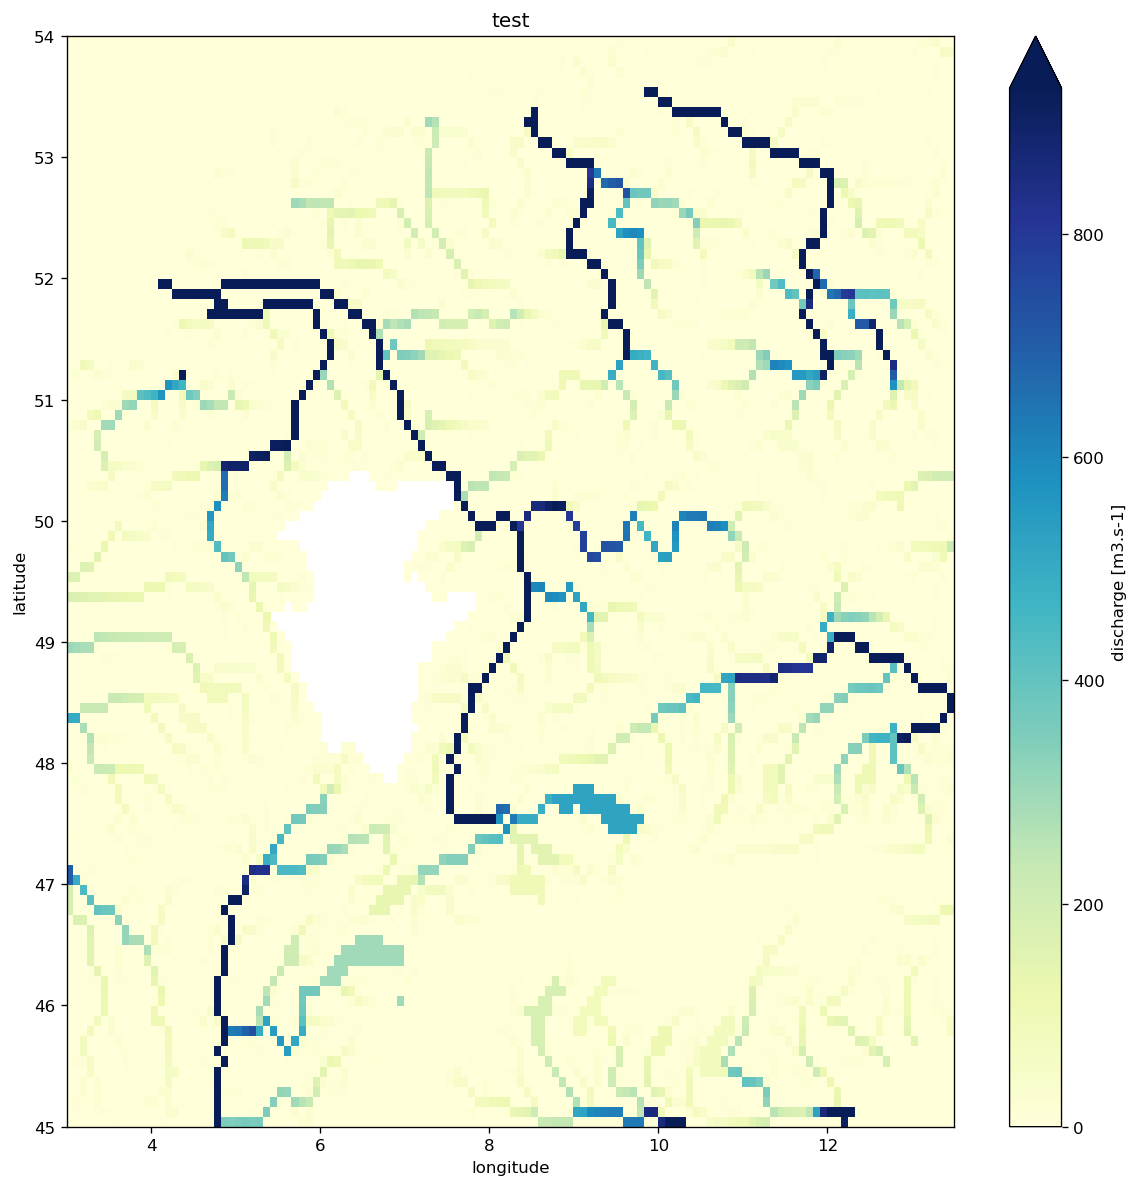

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), dpi=120)

dataExp.isel(time=-1).plot(ax=axs, cmap='YlGnBu', robust=True)
axs.set_title('test')
plt.tight_layout()
fig.savefig(f'pcrglobwb_RolfTestRhine_discharge_map', bbox_inches='tight', dpi=300)

In [16]:
pad=.2

# Write data for model output at GRDC location to pandas series,
# Use padding and max to correct for GRDC station location error
dataExpAtGRDCLocation = dataExp.sel(longitude=slice(grdc_lon-pad, grdc_lon+pad), 
                         latitude=slice(grdc_lat-pad, grdc_lat+pad)
                        ).max(['longitude', 'latitude']
                        ).rename('ERA5Exp'
                        ).to_dataframe()

dataExpAtGRDCLocation.index=dataExpAtGRDCLocation.index.to_datetimeindex()

dataRefAtGRDCLocation = dataRef.sel(longitude=slice(grdc_lon-pad, grdc_lon+pad), 
                         latitude=slice(grdc_lat-pad, grdc_lat+pad)
                        ).max(['longitude', 'latitude']
                        ).rename('ERA5Ref'
                        ).to_dataframe()

dataRefAtGRDCLocation.index=dataRefAtGRDCLocation.index.to_datetimeindex()



In [17]:
# Combine timeseries of ERA-Interim, ERA5 and GRDC observations in a pandas dataframe
df = pd.concat([dataExpAtGRDCLocation, dataRefAtGRDCLocation, grdc_obs],axis = 1)

# Note: the data come at different time stamps
print(df.head())

# For now, interpolating to get similar sets:
df = df.fillna(method='ffill').dropna()
print(df.head())

                ERA5Exp      ERA5Ref    GRDC
2002-01-01  4551.247559  4551.247559  4120.0
2002-01-02  4682.305664  4709.530273  5010.0
2002-01-03  4199.963867  4644.274902  5220.0
2002-01-04  3453.768555  3974.360352  4460.0
2002-01-05  2125.823975  2586.708740  3570.0
                ERA5Exp      ERA5Ref    GRDC
2002-01-01  4551.247559  4551.247559  4120.0
2002-01-02  4682.305664  4709.530273  5010.0
2002-01-03  4199.963867  4644.274902  5220.0
2002-01-04  3453.768555  3974.360352  4460.0
2002-01-05  2125.823975  2586.708740  3570.0


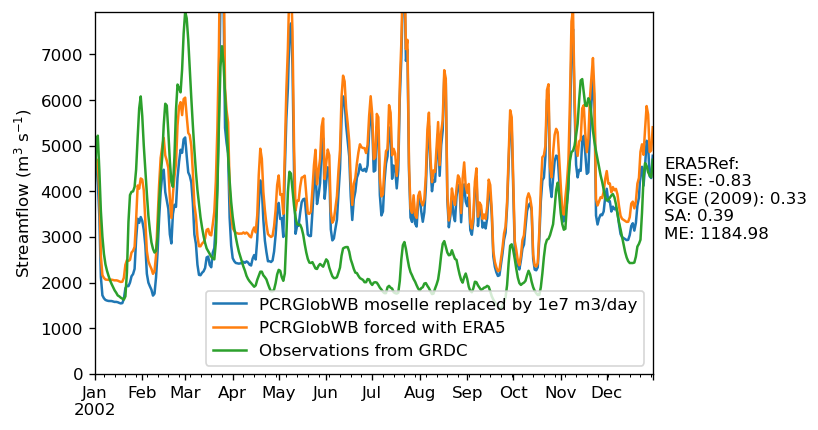

In [18]:
fig, ax = plt.subplots(dpi=120)
df.plot(ax=ax)
ax.set_ylim(0, df.GRDC.max())
ax.set_ylabel('Streamflow (m$^3$ s$^{-1}$)')
ax.legend(['PCRGlobWB moselle replaced by 1e7 m3/day','PCRGlobWB forced with ERA5','Observations from GRDC'])

dataset='ERA5Ref'
yloc=0.6
ax.text(1.02, yloc, f"{dataset}:\n"
        f"NSE: {hm.nse(df[dataset], df['GRDC']):.2f} \n"
        f"KGE (2009): {hm.kge_2009(df[dataset], df['GRDC']):.2f}\n"
        f"SA: {hm.sa(df[dataset], df['GRDC']):.2f}\n"
        f"ME: {hm.me(df[dataset], df['GRDC']):.2f}",
        transform=ax.transAxes, va='top')

fig.savefig(f'pcrglobwb_{basin_name}_hydrograph', bbox_inches='tight', dpi=300)
